# Arima Example


In [194]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [195]:
def test_stationarity(timeseries):

    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()

    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

    #kpss test:
    print('Results of kpss Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [196]:
df=pd.read_csv("/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.ipynb_checkpoints/Electric_Production.csv")
df.DATE=pd.to_datetime(df.DATE)
df.set_index('DATE',inplace=True)
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


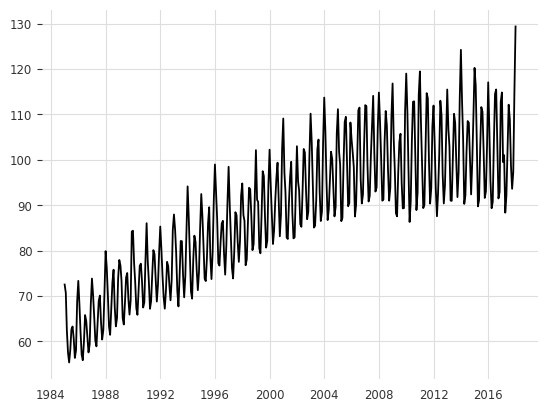

In [197]:
plt.plot(df)
plt.show()

First we'll use a Q test to see if there is autocorrelation in the series to then use an ARIMA model

The null hypothesis is the autocorrelation coefficients are 0. If p<0.05, we reject H0



In [198]:
np.log(df.shape[0])
from statsmodels.stats.diagnostic import acorr_ljungbox
m = int(np.log(df.shape[0]))
acorr_ljungbox(df, lags=[m])

,lb_stat,lb_pvalue
5,983.358302,2.408067e-210


We reject H0, which means there is autocorrelation

In the following plot we can see the rolling mean follows a trend, while the rolling std remains slightly stable. We'll test for stationarity

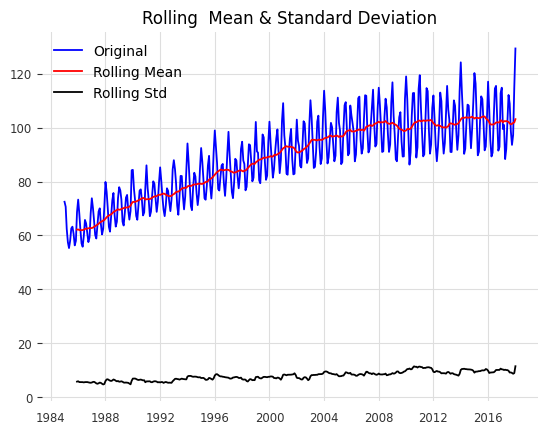

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64
Results of kpss Test:
Test Statistic            3.531597
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/60/7mw96lnj211_m6kjbycw_9200000gn/T/ipykernel_41468/46725829.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [199]:
test_stationarity(df)


In the Dickey-Fuller test, the Null Hypothesis is there exists a unitary root in the series. This would make the series NOT stationary
With a p-value of 0.1862, we can't reject the null hypothesis, so the series is not stationary

In the KPSS Test, the H0 is the time series is stationary. We have a p-value of 0.01, so we reject the null hypothesis. This test also tells us the series isn't stationary. We'll differentiate the series to remove the trend

# Differentiating the series

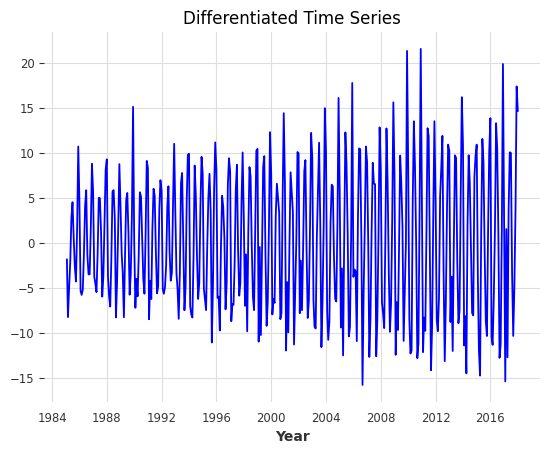

In [200]:
from statsmodels.tsa.statespace.tools import diff
diff_df=diff(df)
plt.plot(diff_df,color='blue')
plt.title("Differentiated Time Series")
plt.xlabel("Year")
plt.show()

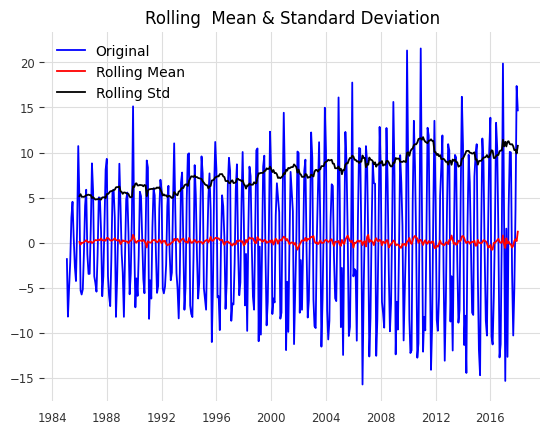

Results of Dickey-Fuller Test:
Test Statistic                -7.104891e+00
p-value                        4.077787e-10
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64
Results of kpss Test:
Test Statistic            0.145189
p-value                   0.100000
#Lags Used               34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/60/7mw96lnj211_m6kjbycw_9200000gn/T/ipykernel_41468/46725829.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [201]:
test_stationarity(diff_df)

In this case, the p-value for Dickey-Fuller makes us reject the H0: Time Series is stationary

KPSS test is 0.1>0.05, so we can't reject the H0. This test also tells us Time Series is stationary

We'll do the Q-test to see if the autocorrelation remains


In [202]:
q_test_diff=acorr_ljungbox(diff_df, lags=[m])
q_test_diff

,lb_stat,lb_pvalue
5,503.147388,1.670635e-106


There is still autocorrelation

# Autocorrelation and Partial Autocorrelation Plots

We can see there are many autocorrelation coefficients following a trend. We'll differentiate the series

In [203]:
def n_time_acf_pacf(data, n):
    """
    Plot the autocorrelation and partial autocorrelation for a time series from 1 to n differentiations.

    Parameters:
        data (pandas.Series or pandas.DataFrame): Time series data.
        n (int): Number of times to differentiate the time series.

    Returns:
        None
    """

    # Create subplots
    fig, axs = plt.subplots(n, 2, figsize=(12, 5 * n))

    for i in range(1, n+1):
        # Perform i times differentiation
        differentiated_data = data
        for _ in range(i):
            differentiated_data = differentiated_data.diff().dropna()

        # Plot ACF and PACF
        plot_acf(differentiated_data, color='red', title=f"Autocorrelation of {i}-time differentiated series", ax=axs[i-1, 0])
        plot_pacf(differentiated_data, color='red', title=f"Partial Autocorrelation of {i}-time differentiated series", ax=axs[i-1, 1])

    plt.tight_layout()
    plt.show()




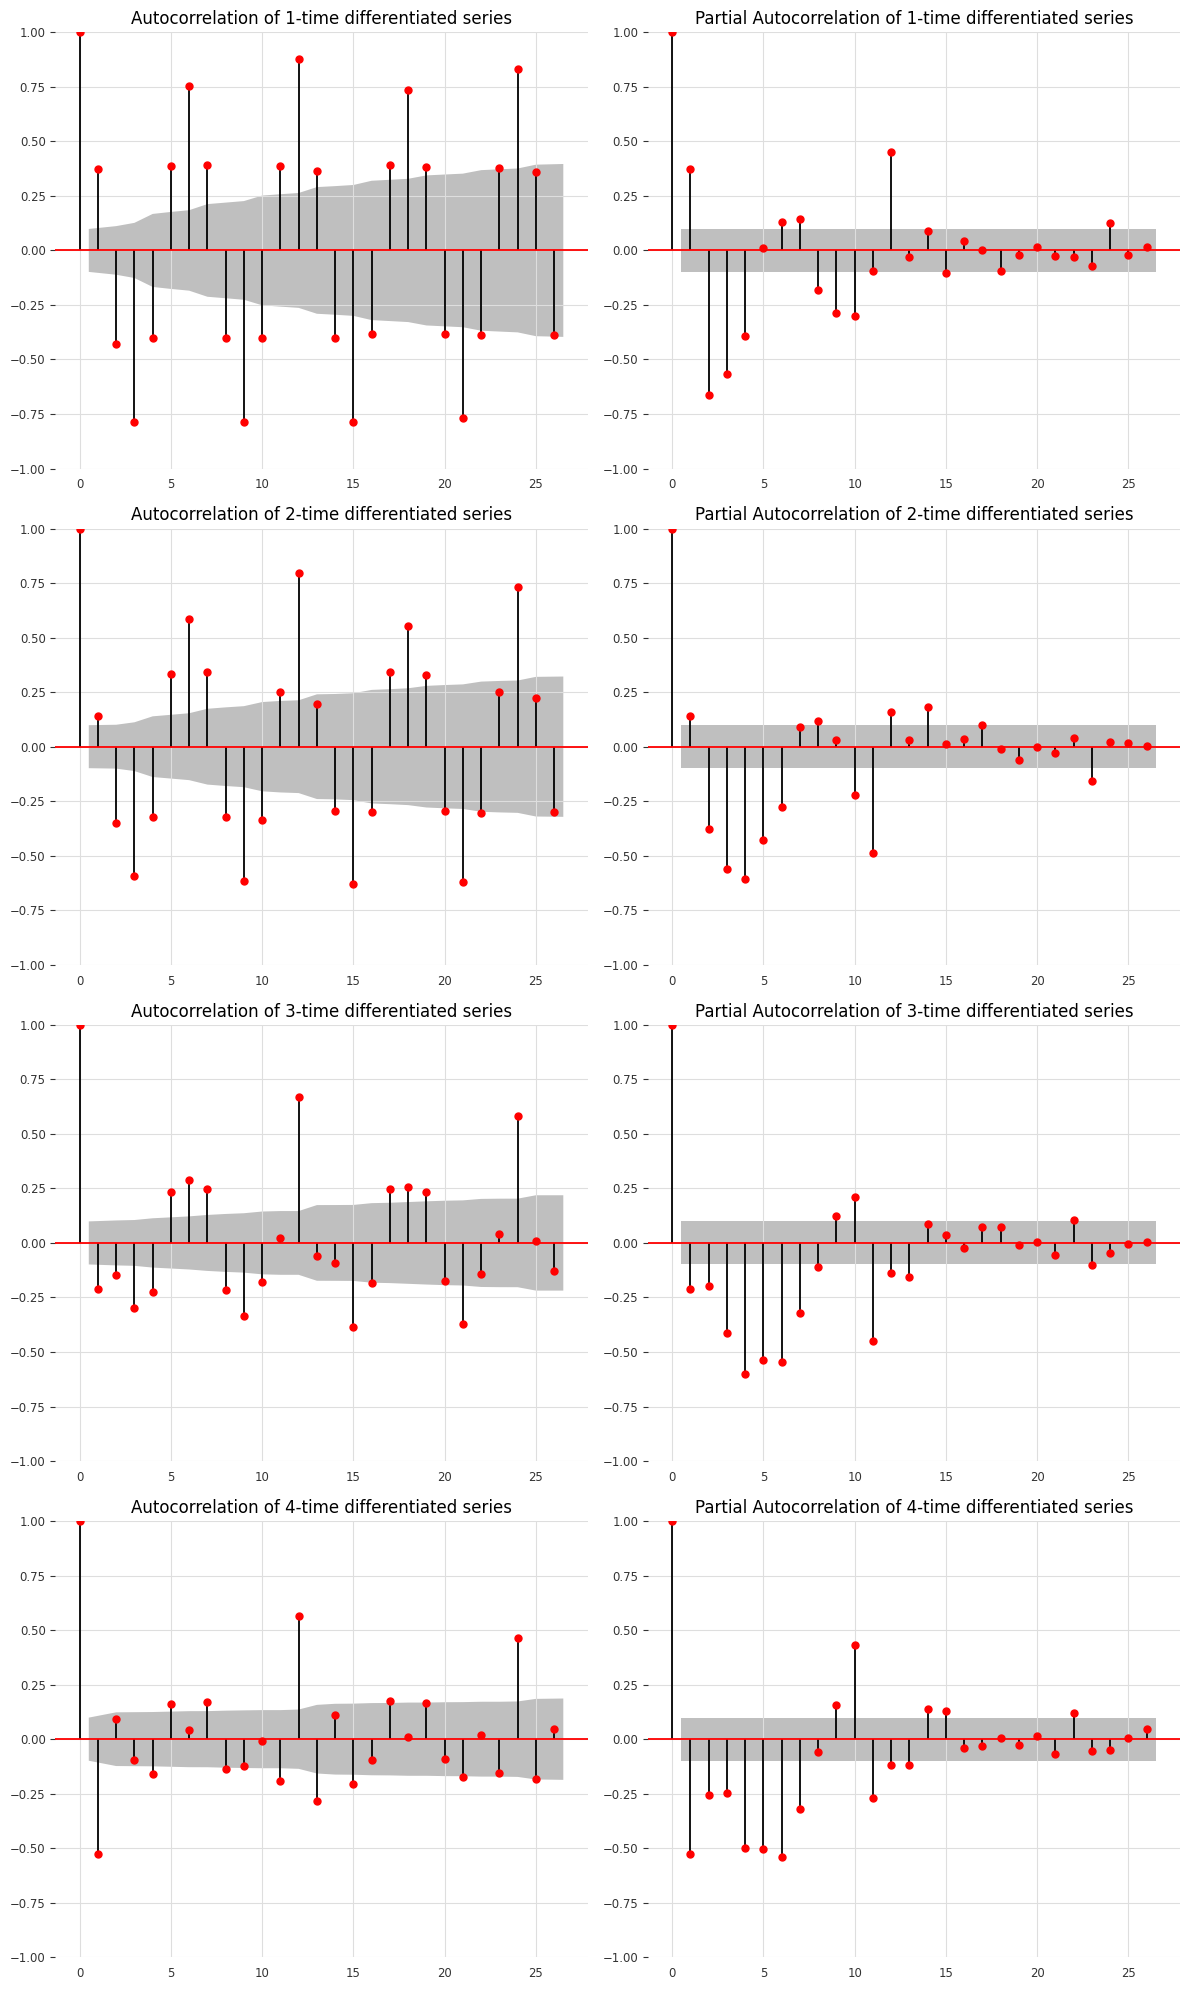

In [204]:
n_time_acf_pacf(df, 4)

# ARIMA MODELS

We see significative autocorrelation and  partial autocorrelation at many different lags

In [205]:
from statsmodels.tsa.arima.model import ARIMA # to do predictions


In [206]:
#Starting with different ARIMA models 
model_1=ARIMA(df,order=(1,1,1))
model_fit1=model_1.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1308.795
Date:                Mon, 08 Apr 2024   AIC                           2623.589
Time:                        10:49:33   BIC                           2635.533
Sample:                    01-01-1985   HQIC                          2628.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.091      0.805      0.421      -0.105       0.251
ma.L1          0.5450      0.070      7.737      0.000       0.407       0.683
sigma2        43.4248      3.296     13.175      0.0

/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Now we'll apply tests to the residuals

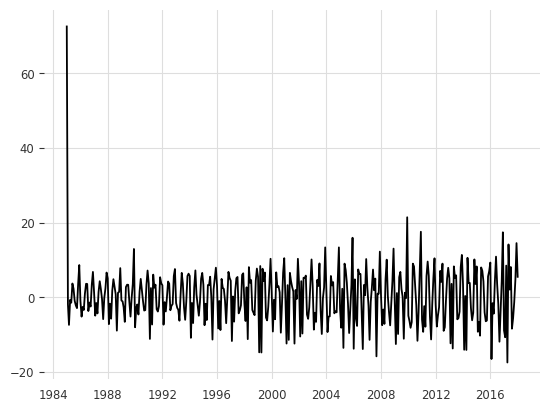

In [207]:
residuals1=pd.DataFrame(model_fit1.resid,columns=['res'])
plt.plot(residuals1)
plt.show()

In [208]:
#Q-test
acorr_ljungbox(residuals1,lags=[m])

,lb_stat,lb_pvalue
5,134.18903,3.071066e-27


In [209]:
#Sum of squred errors
residuals1['res2']=residuals1['res']*residuals1['res']
SSE1=residuals1['res2'].sum()
SSE1

22459.456160485403

In [210]:
model_2=ARIMA(df,order=(3,7,1))
model_fit2=model_2.fit()
print(model_fit2.summary())

/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(3, 7, 1)   Log Likelihood               -1829.182
Date:                Mon, 08 Apr 2024   AIC                           3668.365
Time:                        10:49:34   BIC                           3688.195
Sample:                    01-01-1985   HQIC                          3676.226
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4818      0.054    -27.191      0.000      -1.589      -1.375
ar.L2         -1.0507      0.087    -12.045      0.000      -1.222      -0.880
ar.L3         -0.3350      0.058     -5.763      0.0

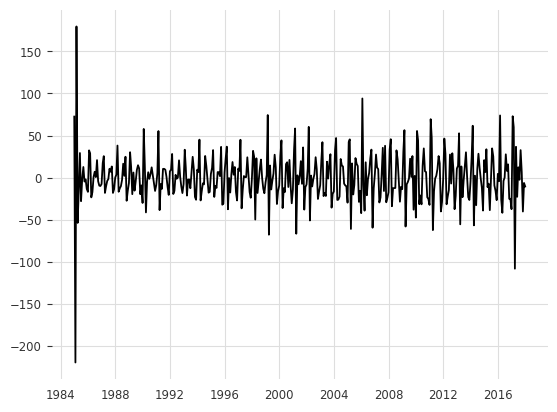

SSE= 357146.7240852546


In [211]:
residuals2=pd.DataFrame(model_fit2.resid,columns=['res'])
plt.plot(residuals2)
plt.show()
acorr_ljungbox(residuals2,[m])
residuals2['res2']=residuals2['res']*residuals2['res']
sse2 = residuals2['res2'].sum()
print('SSE=',sse2)

/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diegohermosillo/Desktop/8 Semestre/Desarrollo de proyectos de ingeniería/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                ARIMA(1, 1, 10)   Log Likelihood               -1134.810
Date:                Mon, 08 Apr 2024   AIC                           2293.620
Time:                        10:49:38   BIC                           2341.397
Sample:                    01-01-1985   HQIC                          2312.548
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0886      0.414      0.214      0.831      -0.723       0.900
ma.L1         -0.1075      0.411     -0.262      0.794      -0.913       0.698
ma.L2         -0.6604      0.057    -11.684      0.0

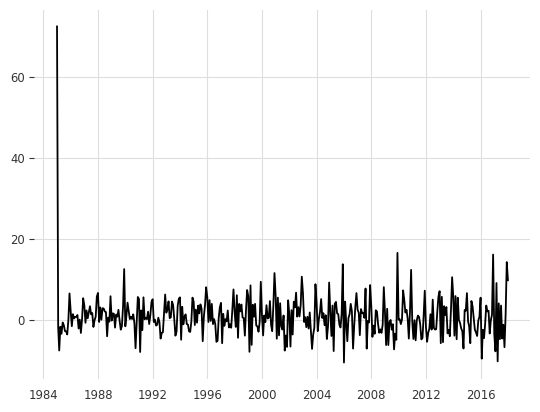

SSE= 12369.308918491566


In [212]:
model_3=ARIMA(df,order=(1,1,10))
model_fit3=model_3.fit()
print(model_fit3.summary())
residuals3=pd.DataFrame(model_fit3.resid,columns=['res'])
plt.plot(residuals3)
plt.show()
acorr_ljungbox(residuals3,[m])
residuals3['res2']=residuals3['res']*residuals3['res']
sse3 = residuals3['res2'].sum()
print('SSE=',sse3)

In [213]:
model_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                ARIMA(1, 1, 10)   Log Likelihood               -1134.810
Date:                Mon, 08 Apr 2024   AIC                           2293.620
Time:                        10:49:38   BIC                           2341.397
Sample:                    01-01-1985   HQIC                          2312.548
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0886      0.414      0.214      0.831      -0.723       0.900
ma.L1         -0.1075      0.411     -0.262      0.794      -0.913       0.698
ma.L2         -0.6604      0.057    -11.684      0.000      -0.771      -0.550
ma.L3         -0.4463      0.270     -1.655      0.098      -0.975       0.082
ma.L4         -0.3457      0.194     -1.785      0.074      -0.725       0.034
ma.L5          0.1125      0.141      0.797      0.425      -0.164       0.389
ma.L6          0.5037      0.075      6.716      0.000       0.357       0.651
ma.L7          0.5274      0.200      2.643      0.008       0.136       0.919
ma.L8          0.0772      0.222      0.347      0.728      -0.358       0.513
ma.L9         -0.4110      0.051     -8.075      0.000      -0.511      -0.311
ma.L10        -0.0935      0.181     -0.517      0.605      -0.448       0.261
sigma2        17.8224      1.123     15.866      0.000      15.621      20.024
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                30.10
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Coefficients are relevant if they are less than 0.05

The standard deviation of the innovations that appears in the table is the standard deviation of the normal distribution of the noise $Z_t$. The variance can be also calculated as:

# Auto ARIMA

In [214]:
from pmdarima.arima import auto_arima

In [215]:
model = auto_arima(df, trace=True, error_action='raise')
autoArimaRes=model.fit(df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2525.516, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2449.577, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2431.710, Time=0.45 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2431.461, Time=0.27 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2359.635, Time=0.37 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2

We can see the AutoArima finds the best parameters as (2,1,4)

In [217]:
autoArimaRes

ARIMA(order=(2, 1, 4), scoring_args={}, suppress_warnings=True)